<a href="https://colab.research.google.com/github/kjquisper/Calculadora/blob/main/Copia_de_05_CLIP_IA_ESIS_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. CLIP

In [1]:
!wget https://github.com/ichaparroc/IA-ESIS-UNJBG/raw/main/GenAI.zip
!unzip GenAI.zip

--2024-07-31 20:09:48--  https://github.com/ichaparroc/IA-ESIS-UNJBG/raw/main/GenAI.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ichaparroc/IA-ESIS-UNJBG/main/GenAI.zip [following]
--2024-07-31 20:09:48--  https://raw.githubusercontent.com/ichaparroc/IA-ESIS-UNJBG/main/GenAI.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24221606 (23M) [application/zip]
Saving to: ‘GenAI.zip’

GenAI.zip           100%[===================>]  23.10M  --.-KB/s    in 0.08s   

2024-07-31 20:09:49 (304 MB/s) - ‘GenAI.zip’ saved [24221606/24221606]

Archive:  GenAI.zip
   creating: images/
  inflating:

Contrastive Language-Image Pre-Training o [CLIP](https://github.com/openai/CLIP/tree/main) es una herramienta de codificación de texto e imagen utilizada con muchos modelos populares de IA Generativa como [DALL-E](https://openai.com/dall-e-2) y [Stable Diffusion](https://github.com/Stability-AI/stablediffusion).

CLIP en sí mismo no es un modelo de IA Generativa, sino que se utiliza para alinear codificaciones de texto con codificaciones de imagen. Si existe la descripción textual perfecta de una imagen, el objetivo de CLIP es crear la misma incrustación vectorial tanto para la imagen como para el texto. Veamos qué significa esto en la práctica.

Los objetivos de este cuaderno son:
* Aprender a utilizar las codificaciones CLIP
  * Obtener una codificación de imagen
  * Obtener una codificación de texto
  * Calcular la similitud coseno entre ellas
* Usar CLIP para crear una red neuronal texto-imagen

## 5.1 Codificaciones

Primero, carguemos las librerías necesarias para este ejercicio.

In [2]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.0 MB/s eta 0:00:00


In [3]:
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Visualization tools
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import save_image, make_grid
from textwrap import wrap

# User defined libraries
from utils import other_utils
from utils import ddpm_utils
from utils import UNet_utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Existen algunas variantes de CLIP basadas en las redes neuronales de reconocimiento de imágenes más conocidas:

In [4]:
pip install openai-clip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.8 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368606 sha256=fdf95fe7860291cb7816f3203b456f4c1063cf15c3ea2d98c87e60d5b0029b47
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [5]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Para este cuaderno, utilizaremos `ViT-B/32`, que se basa en la arquitectura [Vision Transformer](https://huggingface.co/docs/transformers/main/model_doc/vit). Dispone de 512 características, que más tarde introduciremos en nuestro modelo de difusión.

In [6]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 67.2MiB/s]


### 5.1.1 Codificaciones de imagen

Cuando carguemos CLIP, también vendrá con un conjunto de transformaciones de imagen que podemos utilizar para introducir imágenes en el modelo CLIP:

In [7]:
clip_preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7816852125f0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

Podemos probarlo con una de nuestras fotos de flores. Empecemos con una pintoresca **margarita**.

In [8]:
DATA_DIR = "data/cropped_flowers/"
img_path = DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg"
img = Image.open(img_path)
img.show()

Podemos encontrar la incrustación CLIP transformando primero nuestra imagen con `clip_preprocess` y convirtiendo el resultado en un tensor. Dado que el `clip_model` espera un lote de imágenes, podemos utilizar [np.stack](https://numpy.org/doc/stable/reference/generated/numpy.stack.html) para convertir la imagen procesada en un lote de un solo elemento.

In [9]:
clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
clip_imgs.size()

torch.Size([1, 3, 224, 224])

A continuación, podemos pasar el lote a `clip_model.encode_image` para encontrar la incrustación de la imagen. Descomenta `clip_img_encoding` si quieres ver cómo es una codificación. Cuando imprimimos el tamaño, aparece `512` características para nuestra imagen `1`.

In [10]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())
#clip_img_encoding

torch.Size([1, 512])


### 5.1.2 Codificaciones de texto

Ahora que tenemos una codificación de imagen, veamos si podemos obtener una codificación de texto que se corresponda. A continuación se muestra una lista de diferentes descripciones de flores. Como en el caso de las imágenes, el texto debe ser preprocesado antes de ser codificado por CLIP. Para ello, CLIP incluye una función `tokenize` que convierte cada palabra en un número entero.

In [11]:
text_list = [
    "A round white daisy with a yellow center",
    "An orange sunflower with a big brown center",
    "A red rose bud"
]
text_tokens = clip.tokenize(text_list).to(device)
text_tokens

tensor([[49406,   320,  2522,  1579, 12865,   593,   320,  4481,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   550,  4287, 21559,   593,   320,  1205,  2866,  2119, 49407,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

A continuación, podemos pasar los tokens a `encode_text` para obtener nuestras codificaciones de texto. Descomenta `clip_text_encodings` si quieres ver el aspecto de una codificación. Similar a nuestra codificación de imagen, hay `512` características para cada una de nuestras `3` imágenes.

In [12]:
clip_text_encodings = clip_model.encode_text(text_tokens).float()
print(clip_text_encodings.size())
#clip_text_encodings

torch.Size([3, 512])


### 5.1.3 Similaridad

Para ver cuál de nuestras descripciones de texto describe mejor la margarita, podemos calcular la [similitud de coseno](https://medium.com/@milana.shxanukova15/cosine-distance-and-cosine-similarity-a5da0e4d9ded) entre las codificaciones de texto y las codificaciones de imagen. Cuando la similitud de coseno es `1`, es una coincidencia perfecta. Cuando la similitud de coseno es `-1`, las dos codificaciones son opuestas.

La similitud de coseno es equivalente a un [producto escalar](https://mathworld.wolfram.com/DotProduct.html) con cada vector normalizado por su magnitud. En otras palabras, la magnitud de cada vector se convierte en `1`.

Podemos utilizar la siguiente fórmula para calcular el producto escalar:

$X \cdot Y = \sum_{i=1}^{n} x_i y_i = x_1y_1 + x_2 y_2 + \cdots + x_n y_n$

Practiquémoslo un poco.

Intentemos cambiar `x1`, `y1`, `x2` e `y2` por un valor entre -`1` y `1`. Cuando las flechas están alineadas, la similitud del coseno es `1`. Cuando las flechas apuntan en direcciones opuestas, la similitud es `-1`.

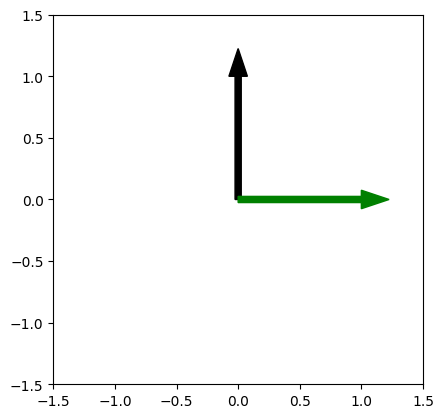

Cosine Similarity: 0.0


In [13]:
x1, y1 = [0, 1] # Change me
x2, y2 = [1, 0] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

# Ejercico 1

Crea nuevas celdas con el código de la celda anterior, probando los siguientes valores.

`x1, y1 = [0, 0.5]` </br>
`x2, y2 = [0, 1]`

`x1, y1 = [0, -1]` </br>
`x2, y2 = [0, 0.5]`

`x1, y1 = [1, 1]` </br>
`x2, y2 = [0, 1]`

Para cada uno describe cuál es el significado del valor obtenido de la similaridad coseno.

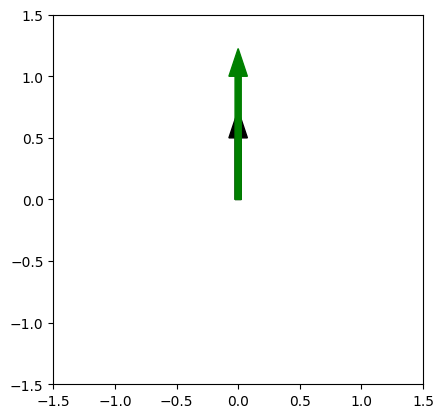

Cosine Similarity: 1.0


In [15]:
x1, y1 = [0, 0.5] # Change me
x2, y2 = [0, 1] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

**Esto indica que la descripción textual y la imagen están en perfecta concordancia. En otras palabras, la descripción textual dada representa exactamente lo que se muestra en la imagen , en este caso la margarita**

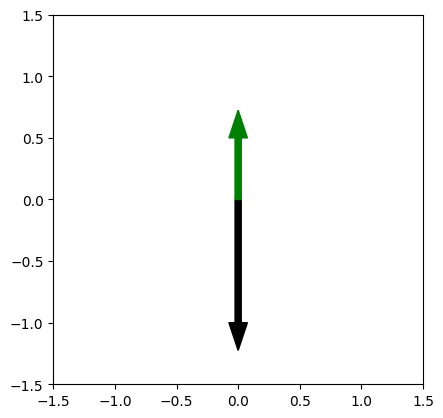

Cosine Similarity: -1.0


In [16]:
x1, y1 = [0, -1] # Change me
x2, y2 = [0, 0.5] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

**En este caso, la descripción textual es completamente incorrecta o contraria a lo que muestra la imagen. Los conceptos que representan el texto y la imagen son totalmente opuestos, lo que significa que el texto esta describiendo una imagen totalmente diferente**

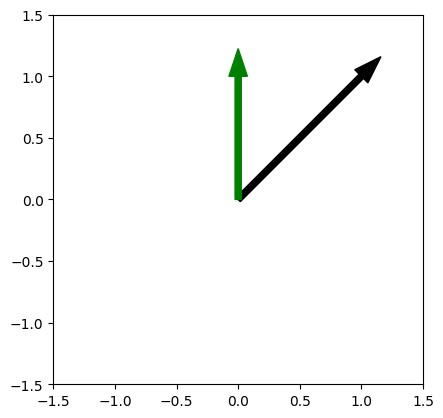

Cosine Similarity: 0.7071067811865475


In [17]:
x1, y1 = [1, 1] # Change me
x2, y2 = [0, 1] # Change me

p1 = [x1, y1]
p2 = [x2, y2]

arrow_width = 0.05
plt.axis('square')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.arrow(0, 0, x1, y1, width=arrow_width, color="black")
plt.arrow(0, 0, x2, y2, width=arrow_width, color="green")
plt.show()

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

**En este caso, la descripción textual tiene una cierta relevancia con la imagen, pero no es una correspondencia exacta. Esto podría significar que la descripción es parcialmente correcta**

La similitud de cosenos también funciona con vectores multidimensionales, aunque son más difíciles de representar gráficamente en una superficie 2D.

In [18]:
p1 = [1, 8, 6, 7]
p2 = [5, 3, 0, 9]

cosine = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
print("Cosine Similarity:", cosine)

Cosine Similarity: 0.7004760286167305


Intentemos calcular la puntuación de similitud para nuestras codificaciones CLIP.

In [19]:
clip_img_encoding /= clip_img_encoding.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)
similarity = (clip_text_encodings * clip_img_encoding).sum(-1)
similarity

tensor([0.3707, 0.2473, 0.1768], device='cuda:0', grad_fn=<SumBackward1>)

A continuación imprimiremos cada texto seguido de su valor de similaridad.

In [20]:
for idx, text in enumerate(text_list):
    print(text, " - ", similarity[idx])

A round white daisy with a yellow center  -  tensor(0.3707, device='cuda:0', grad_fn=<SelectBackward0>)
An orange sunflower with a big brown center  -  tensor(0.2473, device='cuda:0', grad_fn=<SelectBackward0>)
A red rose bud  -  tensor(0.1768, device='cuda:0', grad_fn=<SelectBackward0>)


# Ejercico 2

**¿Cuál es el texto con mayor valor?**

"A round white daisy with a yellow center" (0.3707, device='cuda:0', grad_fn=<SelectBackward0>).

**¿El texto con mayor valor describe una margarita? ¿Por qué?**

Si,  El valor de similitud más alto indica que esta descripción es la que mejor corresponde con la codificación de la imagen, que se presume es la de una margarita , esto debido a que se describe con mayor precisión los atributos de la imagen de la margarita, comparado con las otras descripciones proporcionadas. Esto sugiere que CLIP ha identificado correctamente la correspondencia entre la descripción textual y los elementos visuales presentes en la imagen de la margarita.

Practiquemos un poco más. A continuación, procesaremos la imagen de una **margarita, girasol y rosa**. hasta obtener su representación vectorial o embedding.

In [21]:
img_paths = [
    DATA_DIR + "daisy/2877860110_a842f8b14a_m.jpg",
    DATA_DIR + "sunflowers/2721638730_34a9b7a78b.jpg",
    DATA_DIR + "roses/8032328803_30afac8b07_m.jpg"
]

imgs = [Image.open(path) for path in img_paths]
for img in imgs:
    img.show()

In [22]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

In [23]:
clip_img_encodings = get_img_encodings(imgs)
clip_img_encodings

tensor([[-0.2717, -0.0157, -0.1792,  ...,  0.5811,  0.0866, -0.1448],
        [ 0.2595, -0.1020, -0.3438,  ..., -0.0073,  0.4958,  0.0819],
        [-0.0620,  0.4136,  0.0090,  ...,  0.3269,  0.4626, -0.1388]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)

Ahora, calcularemos la representación vectorial o embedding de los siguientes textos.

In [24]:
text_list = [
    "A round white daisy with a yellow center", #"Una margarita blanca redonda con un centro amarillo",
    "An orange sunflower with a big brown center", #"Un girasol naranja con un gran centro marrón",
    "A deep red rose flower" #"Una rosa de color rojo intenso"
]

In [25]:
text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()
clip_text_encodings

tensor([[-0.5107,  0.1919,  0.1963,  ...,  0.0949, -0.0848, -0.2783],
        [ 0.0224,  0.3889,  0.3506,  ...,  0.1219,  0.0778, -0.1910],
        [-0.1094,  0.0110,  0.3333,  ...,  0.1288, -0.1019, -0.1853]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

Sería bueno comparar cada combinación de texto e imagen. Para ello, podemos [repetir](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html#torch.Tensor.repeat) cada codificación de texto para cada codificación de imagen. De manera similar, podemos [repetir_interleave](https://pytorch.org/docs/stable/generated/torch.repeat_interleave.html) cada codificación de imagen para cada codificación de texto.

In [26]:
clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

n_imgs = len(imgs)
n_text = len(text_list)

In [27]:
repeated_clip_text_encodings = clip_text_encodings.repeat(n_imgs, 1)
repeated_clip_text_encodings

tensor([[-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228],
        ...,
        [-0.0729,  0.0274,  0.0280,  ...,  0.0135, -0.0121, -0.0397],
        [ 0.0031,  0.0545,  0.0492,  ...,  0.0171,  0.0109, -0.0268],
        [-0.0135,  0.0014,  0.0410,  ...,  0.0158, -0.0125, -0.0228]],
       device='cuda:0', grad_fn=<RepeatBackward0>)

In [28]:
repeated_clip_img_encoding = clip_img_encodings.repeat_interleave(n_text, dim=0)
repeated_clip_img_encoding

tensor([[-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        [-0.0247, -0.0014, -0.0163,  ...,  0.0528,  0.0079, -0.0132],
        ...,
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120],
        [-0.0053,  0.0356,  0.0008,  ...,  0.0282,  0.0399, -0.0120]],
       device='cuda:0', dtype=torch.float16, grad_fn=<ViewBackward0>)

In [29]:
similarity = (repeated_clip_text_encodings * repeated_clip_img_encoding).sum(-1)
similarity = torch.unflatten(similarity, 0, (n_text, n_imgs))
similarity

tensor([[0.3705, 0.2471, 0.1943],
        [0.2647, 0.2993, 0.1810],
        [0.1700, 0.1754, 0.3078]], device='cuda:0', grad_fn=<ViewBackward0>)

Comparemos. Lo ideal sería que la diagonal desde la parte superior izquierda hasta la inferior derecha fuera de un amarillo brillante, correspondiente a su valor alto. El resto de los valores deberían ser bajos y de color azul.

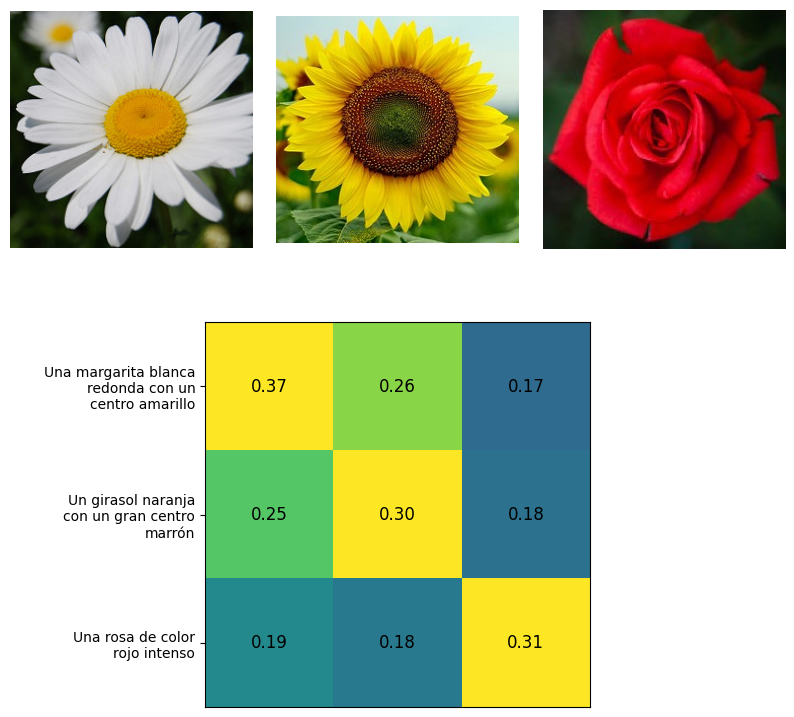

In [32]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

text_list = [
    "Una margarita blanca redonda con un centro amarillo",
    "Un girasol naranja con un gran centro marrón",
    "Una rosa de color rojo intenso"
]

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(n_text), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

# Ejercicio 3

**¿Son correctos los resultados?**

Si son correctos

**¿Por qué?**

porque Los valores más altos de similitud se encuentran en la diagonal de la matriz (0.37, 0.30 , 0.31), donde cada imagen es comparada con su correspondiente descripción textual, esto significa que el modelo ha identificado correctamente las imágenes y las ha relacionado con las descripciones textuales adecuadas.

# Ejercicio 4

Cree nuevas celdas en las cuales compare 3 imágenes de internet y 3 textos (en inglés).
Ejemplo: Puede usar una foto de las pirámides de egipto, Machu Picchu y Cristo Redendor, luego crear 3 textos descriptivos en inglés e imprimir la matriz de similaridad (ya no vale usazr este ejemplo).

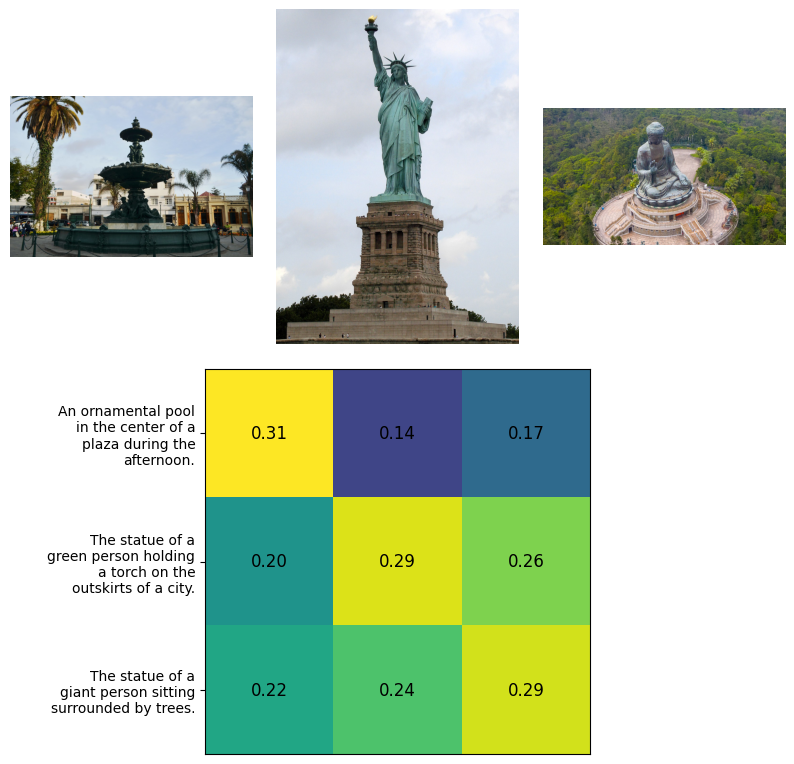

In [37]:
import matplotlib.pyplot as plt
from textwrap import wrap
from PIL import Image
import torch
from transformers import CLIPProcessor, CLIPModel

# Cargar el modelo y el procesador CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Definir los textos descriptivos
text_list = [
    "An ornamental pool in the center of a plaza during the afternoon.",
    "The statue of a green person holding a torch on the outskirts of a city.",
    "The statue of a giant person sitting surrounded by trees."
]

# Cargar las imágenes proporcionadas
image_paths = [
    "/content/imagenes_ejemplos/pileta_tacna.jpg",
    "/content/imagenes_ejemplos/estatua_de_la_libertad.jpg",
    "/content/imagenes_ejemplos/buda.jpg"
]

imgs = [Image.open(path) for path in image_paths]

# Procesar las imágenes y los textos
inputs = processor(text=text_list, images=imgs, return_tensors="pt", padding=True)

# Obtener las representaciones vectoriales
with torch.no_grad():
    outputs = model(**inputs)

# Extraer las representaciones de texto e imagen
image_features = outputs.image_embeds
text_features = outputs.text_embeds

# Calcular la matriz de similitud coseno
similarity = torch.nn.functional.cosine_similarity(image_features.unsqueeze(1), text_features.unsqueeze(0), dim=-1)

# Visualizar las imágenes y la matriz de similitud
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

for i, img in enumerate(imgs):
    ax = fig.add_subplot(gs[0, i])
    ax.axis("off")
    plt.imshow(img)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(len(text_list)), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)



## 5.2 Un conjunto de datos CLIP

En el cuaderno anterior, usamos la categoría de flores como etiqueta. Esta vez, vamos a usar las codificaciones CLIP como nuestra etiqueta.

Si el objetivo de CLIP es alinear las codificaciones de texto con las codificaciones de imagen, ¿necesitamos una descripción de texto para cada una de las imágenes en nuestro conjunto de datos? Hipótesis: no necesitamos descripciones de texto y solo necesitamos las codificaciones CLIP de imagen para crear una secuencia de conversión de texto a imagen.

Para probar esto, agreguemos las codificaciones CLIP como la "etiqueta" a nuestro conjunto de datos. Ejecutar CLIP en cada lote de imágenes aumentadas con datos sería más preciso, pero también es más lento. Podemos acelerar las cosas preprocesando y almacenando las codificaciones con anticipación.

Podemos usar [glob](https://docs.python.org/3/library/glob.html) para enumerar todas las rutas de archivo de nuestras imágenes:

In [38]:
data_paths = glob.glob(DATA_DIR + '*/*.jpg', recursive=True)
data_paths[:5]

['data/cropped_flowers/daisy/21626652132_97e1318bb8_m.jpg',
 'data/cropped_flowers/daisy/5981645737_29eceac291_m.jpg',
 'data/cropped_flowers/daisy/11642632_1e7627a2cc.jpg',
 'data/cropped_flowers/daisy/15306268004_4680ba95e1.jpg',
 'data/cropped_flowers/daisy/7189043225_2fe781439a_n.jpg']

El siguiente bloque de código ejecuta el siguiente bucle para cada ruta de archivo:
* Abrir la imagen asociada con la ruta y almacenarla en `img`
* Preprocesar la imagen, buscar la codificación CLIP y almacenarla en `clip_img`
* Convertir la codificación CLIP de un tensor a una lista de Python
* Almacenar la ruta de archivo y la codificación CLIP como una fila en un archivo csv

In [39]:
import csv

csv_path = 'clip.csv'

with open(csv_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for idx, path in enumerate(data_paths):
        img = Image.open(path)
        clip_img = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
        label = clip_model.encode_image(clip_img)[0].tolist()
        writer.writerow([path] + label)

Puede que el procesamiento del conjunto de datos completo tarde unos segundos. Cuando haya terminado, abra [clip.csv](clip.csv) para ver los resultados.

Podemos utilizar las mismas transformaciones de imágenes que utilizamos con el otro cuaderno:

In [40]:
IMG_SIZE = 32 # Due to stride and pooling, must be divisible by 2 multiple times
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

pre_transforms = [
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
]
pre_transforms = transforms.Compose(pre_transforms)
random_transforms = [
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
]
random_transforms = transforms.Compose(random_transforms)

A continuación se muestra el código para inicializar nuestro nuevo conjunto de datos. Dado que hemos preprocesado el clip, lo cargaremos previamente en nuestra GPU con la función __init__. Hemos mantenido la codificación CLIP "sobre la marcha" como ejemplo. Producirá resultados ligeramente mejores, pero es mucho más lento.

In [41]:
class MyDataset(Dataset):
    def __init__(self, csv_path, preprocessed_clip=True):
        self.imgs = []
        self.preprocessed_clip = preprocessed_clip
        if preprocessed_clip:
            self.labels = torch.empty(
                len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
            )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                if preprocessed_clip:
                    label = [float(x) for x in row[1:]]
                    self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        img = random_transforms(self.imgs[idx])
        if self.preprocessed_clip:
            label = self.labels[idx]
        else:
            batch_img = img[None, :, :, :]
            encoded_imgs = clip_model.encode_image(clip_preprocess(batch_img))
            label = encoded_imgs.to(device).float()[0]
        return img, label

    def __len__(self):
        return len(self.imgs)

In [42]:
train_data = MyDataset(csv_path)
dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

El modelo U-Net es la misma arquitectura que la última vez, pero con una pequeña diferencia. En lugar de utilizar la cantidad de clases como `c_embed_dim`, utilizaremos la cantidad de `CLIP_FEATURES`. La última vez, `c` podría haber significado "clase", pero esta vez, significa "contexto". Afortunadamente, ambos comienzan con `c`, por lo que no necesitamos refactorizar el código para reflejar este cambio en la intención.

In [43]:
T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)

ddpm = ddpm_utils.DDPM(B, device)
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)
print("Num params: ", sum(p.numel() for p in model.parameters()))
model_flowers = torch.compile(model.to(device))

Num params:  44900355


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


The `get_context_mask` function will change a little bit. Since we're replacing our categorical input with a CLIP embedding, we no longer need to one-hot encode our label. We'll still randomly set values in our encoding to `0` to help the model learn without context.

In [44]:
def get_context_mask(c, drop_prob):
    c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
    return c_mask

Recreemos también la función `sample_flowers`. Esta vez, tomará nuestra `text_list` como parámetro y la convertirá a una codificación CLIP. La función `sample_w` sigue siendo prácticamente la misma y se ha movido al final de [ddpm_utils.py](utils/ddpm_utils.py).

In [45]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

¡Es hora de entrenar! Después de aproximadamente 50 épocas, el modelo comenzará a generar algo reconocible y, en 100, alcanzará su máximo potencial. ¿Qué opinas? ¿Las imágenes generadas coinciden con tus descripciones?

In [46]:
epochs=100
c_drop_prob = 0.1
lrate = 1e-4
save_dir = "05_images/"

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lrate)

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x, c = batch
        c_mask = get_context_mask(c, c_drop_prob)
        loss = ddpm.get_loss(model_flowers, x, t, c, c_mask)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()}")
    if epoch % 5 == 0 or epoch == int(epochs - 1):
        x_gen, x_gen_store = sample_flowers(text_list)
        grid = make_grid(x_gen.cpu(), nrow=len(text_list))
        save_image(grid, save_dir + f"image_ep{epoch:02}.png")
        print("saved images in " + save_dir + f" for episode {epoch}")

Epoch 0 | Step 008 | Loss: 0.17464987933635712
saved images in 05_images/ for episode 0
Epoch 1 | Step 008 | Loss: 0.15310510993003845
Epoch 2 | Step 008 | Loss: 0.12704750895500183
Epoch 3 | Step 008 | Loss: 0.12108926475048065
Epoch 4 | Step 008 | Loss: 0.10973504185676575
Epoch 5 | Step 008 | Loss: 0.08750655502080917
saved images in 05_images/ for episode 5
Epoch 6 | Step 008 | Loss: 0.12562695145606995
Epoch 7 | Step 008 | Loss: 0.12470006942749023
Epoch 8 | Step 008 | Loss: 0.09631242603063583
Epoch 9 | Step 008 | Loss: 0.11128652095794678
Epoch 10 | Step 008 | Loss: 0.09532211720943451
saved images in 05_images/ for episode 10
Epoch 11 | Step 008 | Loss: 0.13538073003292084
Epoch 12 | Step 008 | Loss: 0.11599497497081757
Epoch 13 | Step 008 | Loss: 0.0857316255569458
Epoch 14 | Step 008 | Loss: 0.12123414129018784
Epoch 15 | Step 008 | Loss: 0.08407353609800339
saved images in 05_images/ for episode 15
Epoch 16 | Step 008 | Loss: 0.1055009514093399
Epoch 17 | Step 008 | Loss: 0.

Ahora que el modelo está entrenado, ¡juguemos con él! ¿Qué sucede cuando le damos un mensaje de algo que no está en el conjunto de datos? ¿O puedes crear el mensaje perfecto para generar una imagen que puedas imaginar?

El arte de crear un mensaje para obtener los resultados que deseas se llama **ingeniería de mensajes** y, como se muestra aquí, depende del tipo de datos con los que se entrena el modelo.

In [ ]:
# Change me
text_list = [
    "A daisy",
    "A sunflower",
    "A rose"
]

model.eval()
x_gen, x_gen_store = sample_flowers(text_list)
grid = make_grid(x_gen.cpu(), nrow=len(text_list))
other_utils.show_tensor_image([grid])
plt.show()

Una vez que haya encontrado un conjunto de imágenes que le gusten, ejecute la celda a continuación para convertirla en una animación. Se guardará en [05_images/flowers.gif](05_images/flowers.gif)

In [ ]:
grids = [other_utils.to_image(make_grid(x_gen.cpu(), nrow=len(text_list))) for x_gen in x_gen_store]
other_utils.save_animation(grids, "05_images/flowers.gif")

# Ejercicio 5

Cree nuevas celdas en las que genere 3 flores a partir de texto en inglés (A daisy..., A sunflower..., A rose...) pero con características especiales.

Ejemplo (no vale usar el mismo):

```
text_list = [
    "A daisy with big petals",
    "A sunflower with small center",
    "A rose with dark tones"
]
```



## 5.3 Siguientes pasos

¡Felicitaciones por haber llegado al final del curso! Esperamos que hayas disfrutado del proceso y que hayas podido generar algo que valga la pena compartir con tus amigos y familiares.

¿Estás listo para poner a prueba tus habilidades?